In [2]:
import string
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.manifold import TSNE
from synthcity.benchmark import Benchmarks
from synthcity.plugins import Plugins
from synthcity.plugins.core.models.survival_analysis.metrics import (
    nonparametric_distance,
)
from synthcity.plugins.core.models.time_to_event.loader import get_model_template
from synthcity.utils.serialization import dataframe_hash, load_from_file, save_to_file

from datasets import get_dataset

warnings.filterwarnings("ignore")

out_dir = Path("output")
workspace = Path("workspace")

fontsize = 14
plt.style.use("seaborn-whitegrid")

In [3]:
gain_scenarios = [
    (
        "w/o TTE Regressor",
        {
            "uncensoring_model": "date",
            "tte_strategy": "survival_function",
            #             "uncensoring_model": "tenn",
            #             "tte_strategy": "uncensoring",
            "dataloader_sampling_strategy": "none",
            "use_conditional": False,
        },
    ),
    (
        "w/o Imbalanced Sampling",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "none",
            "use_conditional": False,
        },
    ),
    (
        "w/o Temporal Sampling",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "imbalanced_censoring",
            "use_conditional": False,
        },
    ),
    (
        "w/o Cond. GAN ",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "imbalanced_time_censoring",
            "use_conditional": False,
        },
    ),
]

## Metrics

In [18]:
import json

import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter
from sklearn.manifold import TSNE
from synthcity.utils.serialization import dataframe_hash, load_from_file, save_to_file

from plots import plot_survival_grouped, plot_survival_individual

plugin = "survival_gan"
repeat = 0
fontsize = 16


def map_dataset(d):
    if d == "maggic":
        return "pheart"

    return d


def plot_survival_grouped(
    scenario: str,
    title: str,
    T: pd.Series,
    E: pd.Series,
    preds: list,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
) -> None:
    fig, axs = plt.subplots(
        1, len(preds), figsize=(4 * len(preds), 3), constrained_layout=True
    )

    models = []
    for idx, pred in enumerate(preds):
        ax = axs[idx]
        syn_label, syn_T, syn_E = pred
        gt_kmf = KaplanMeierFitter()
        gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
        ax = gt_kmf.plot(
            ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
        )

        syn_kmf = KaplanMeierFitter()
        syn_kmf.fit(
            syn_T, syn_E, label=syn_label
        )  # t = Timepoints, Rx: 0=censored, 1=event
        syn_kmf.plot(
            ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
        )

        ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
        ax.set_xlabel("", fontsize=14)

        ax.set_xlabel("Time", horizontalalignment="center", fontsize=14)
        ax.set_title(title)

    axs[0].set_ylabel("Event probability", fontsize=14)

    plt.show()


def generate_score(metric: np.ndarray) -> tuple:
    percentile_val = 1.96
    score = (np.mean(metric), percentile_val * np.std(metric) / np.sqrt(len(metric)))

    return round(score[0], 4), round(score[1], 4)


def generate_score_str(metric: np.ndarray) -> str:
    mean, std = generate_score(metric)
    return str(mean) + " +/- " + str(std)


def plot_km(
    ax,
    title,
    T: pd.Series,
    E: pd.Series,
    syn_T: pd.Series,
    syn_E: pd.Series,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
    syn_label: str = None,
    xaxis_label: str = "",
    yaxis_label: str = None,
    show_title: bool = True,
    legend=False,
) -> None:
    gt_kmf = KaplanMeierFitter()
    gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
    ax = gt_kmf.plot(
        ax=ax,
        ci_show=ci_show,
        ci_alpha=ci_alpha,
        show_censors=show_censors,
        legend=legend,
    )

    if syn_label is None:
        syn_label = "Synthetic data"

    syn_kmf = KaplanMeierFitter()
    syn_kmf.fit(
        syn_T, syn_E, label=syn_label
    )  # t = Timepoints, Rx: 0=censored, 1=event
    ax = syn_kmf.plot(
        ax=ax,
        ci_show=ci_show,
        ci_alpha=ci_alpha,
        show_censors=show_censors,
        legend=legend,
    )
    ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
    if xaxis_label is not None:
        ax.set_xlabel(xaxis_label, horizontalalignment="center", fontsize=fontsize)

    if yaxis_label is not None:
        ax.set_ylabel(yaxis_label, fontsize=fontsize)


def plot_tsne(ax, proj_real: pd.DataFrame, df_syn: pd.DataFrame,) -> None:
    tsne_syn = TSNE(n_components=2, random_state=0)
    proj_syn = pd.DataFrame(tsne_syn.fit_transform(df_syn))

    ax.scatter(x=proj_real[0], y=proj_real[1], s=3, alpha=0.8, label="Real data")
    ax.scatter(x=proj_syn[0], y=proj_syn[1], s=3, alpha=0.8, label="Synthetic data")
    ax.set_ylabel("Covariate diversity(t-SNE)", fontsize=fontsize)


def plot_gain(dataset, repeat=0):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    T = df[duration_col]
    E = df[event_col]

    fig, axs = plt.subplots(
        1, len(gain_scenarios) + 1, figsize=(5 * (len(gain_scenarios) + 1), 4)
    )

    preds = []
    experiment_name = dataframe_hash(df)

    cache_file = workspace / f"{experiment_name}_{plugin}_{repeat}.bkp"

    X_syn = load_from_file(cache_file)
    syn_T = X_syn[duration_col]
    syn_E = X_syn[event_col]

    plot_km(axs[0], "SurvivalGAN", T, E, syn_T, syn_E)

    local_data = (f"SurvivalGAN", syn_T, syn_E)
    preds.append(local_data)

    results = {}
    for repeat in range(5):
        for idx, (name, scenario_args) in enumerate(gain_scenarios):
            if name not in results:
                results[name] = {
                    "opt": [],
                    "abs_opt": [],
                    "sight": [],
                }

            kwargs_hash = json.dumps(scenario_args, sort_keys=True)
            cache_file = (
                workspace / f"{experiment_name}_{plugin}{kwargs_hash}_{repeat}.bkp"
            )

            if not cache_file.exists():
                continue
            X_syn = load_from_file(cache_file)
            syn_T = X_syn[duration_col]
            syn_E = X_syn[event_col]

            auc_opt, auc_abs_opt, sightedness = nonparametric_distance(
                (T, E), (syn_T, syn_E),
            )
            results[name]["opt"].append(auc_opt)
            results[name]["abs_opt"].append(auc_abs_opt)
            results[name]["sight"].append(sightedness)

            plot_km(axs[idx + 1], name, T, E, syn_T, syn_E)
        plt.suptitle(f"Dataset: {map_dataset(dataset)}", fontsize=18)

        fig_name = Path(f"diagrams/gains_km_plot_grouped_{dataset}.pdf")

        plt.tight_layout()
        plt.show()

    cols = ["model", "opt", "abs_opt", "sight"]
    out = pd.DataFrame([], columns=cols)
    for model in results:
        local = [model]
        for metric in results[model]:
            local.append(generate_score_str(results[model][metric]))
        out = out.append(pd.DataFrame([local], columns=cols))
    return out


def plot_gain_simple(dataset, repeat=0):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    T = df[duration_col]
    E = df[event_col]

    fig, axs = plt.subplots(
        1,
        len(gain_scenarios) + 1,
        figsize=(5 * (len(gain_scenarios) + 1), 4),
        sharey=True,
        sharex=True,
    )

    preds = []
    experiment_name = dataframe_hash(df)

    cache_file = workspace / f"{experiment_name}_{plugin}_{repeat}.bkp"

    X_syn = load_from_file(cache_file)
    syn_T = X_syn[duration_col]
    syn_E = X_syn[event_col]

    plot_km(
        axs[0],
        "SurvivalGAN",
        T,
        E,
        syn_T,
        syn_E,
        legend=True,
        yaxis_label="Survival Probability",
        xaxis_label="SurvivalGAN",
    )

    local_data = (f"SurvivalGAN", syn_T, syn_E)
    preds.append(local_data)

    for idx, (name, scenario_args) in enumerate(gain_scenarios):

        kwargs_hash = json.dumps(scenario_args, sort_keys=True)
        cache_file = workspace / f"{experiment_name}_{plugin}{kwargs_hash}_{repeat}.bkp"

        if not cache_file.exists():
            print("missing", cache_file)
            continue
        X_syn = load_from_file(cache_file)
        syn_T = X_syn[duration_col]
        syn_E = X_syn[event_col]

        plot_km(axs[idx + 1], name, T, E, syn_T, syn_E, legend=False, xaxis_label=name)
    plt.suptitle(f"Dataset: {map_dataset(dataset)}", fontsize=fontsize)

    fig_name = Path(f"diagrams/gains_km_plot_grouped_{dataset}.pdf")
    fig_name_png = Path(f"diagrams/gains_km_plot_grouped_{dataset}.png")

    plt.tight_layout()
    plt.savefig(fig_name)
    plt.savefig(fig_name_png)
    plt.show()


def plot_gain_fidelity(dataset, repeat=0):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    T = df[duration_col]
    E = df[event_col]

    tsne = TSNE(n_components=2, random_state=0)
    proj_real = pd.DataFrame(tsne.fit_transform(df))

    fig, axs = plt.subplots(
        2, len(gain_scenarios) + 1, figsize=(5 * (len(gain_scenarios) + 1), 8)
    )

    preds = []
    experiment_name = dataframe_hash(df)

    cache_file = workspace / f"{experiment_name}_{plugin}_{repeat}.bkp"

    X_syn = load_from_file(cache_file)
    syn_T = X_syn[duration_col]
    syn_E = X_syn[event_col]

    plot_tsne(axs[0][0], proj_real, X_syn)
    plot_km(axs[1][0], "SurvivalGAN", T, E, syn_T, syn_E)

    local_data = (f"SurvivalGAN", syn_T, syn_E)
    preds.append(local_data)

    for idx, (name, scenario_args) in enumerate(gain_scenarios):

        kwargs_hash = json.dumps(scenario_args, sort_keys=True)
        cache_file = workspace / f"{experiment_name}_{plugin}{kwargs_hash}_{repeat}.bkp"

        if not cache_file.exists():
            print("missing", cache_file)
            continue
        X_syn = load_from_file(cache_file)
        syn_T = X_syn[duration_col]
        syn_E = X_syn[event_col]

        plot_tsne(axs[0][idx + 1], proj_real, X_syn)
        plot_km(axs[1][idx + 1], name, T, E, syn_T, syn_E)
    plt.suptitle(f"Dataset: {map_dataset(dataset)}", fontsize=18)

    fig_name = Path(f"diagrams/gains_full_plot_grouped_{dataset}.pdf")
    fig_name_png = Path(f"diagrams/gains_full_plot_grouped_{dataset}.png")

    plt.tight_layout()

    plt.savefig(fig_name)
    plt.savefig(fig_name_png)

    plt.show()

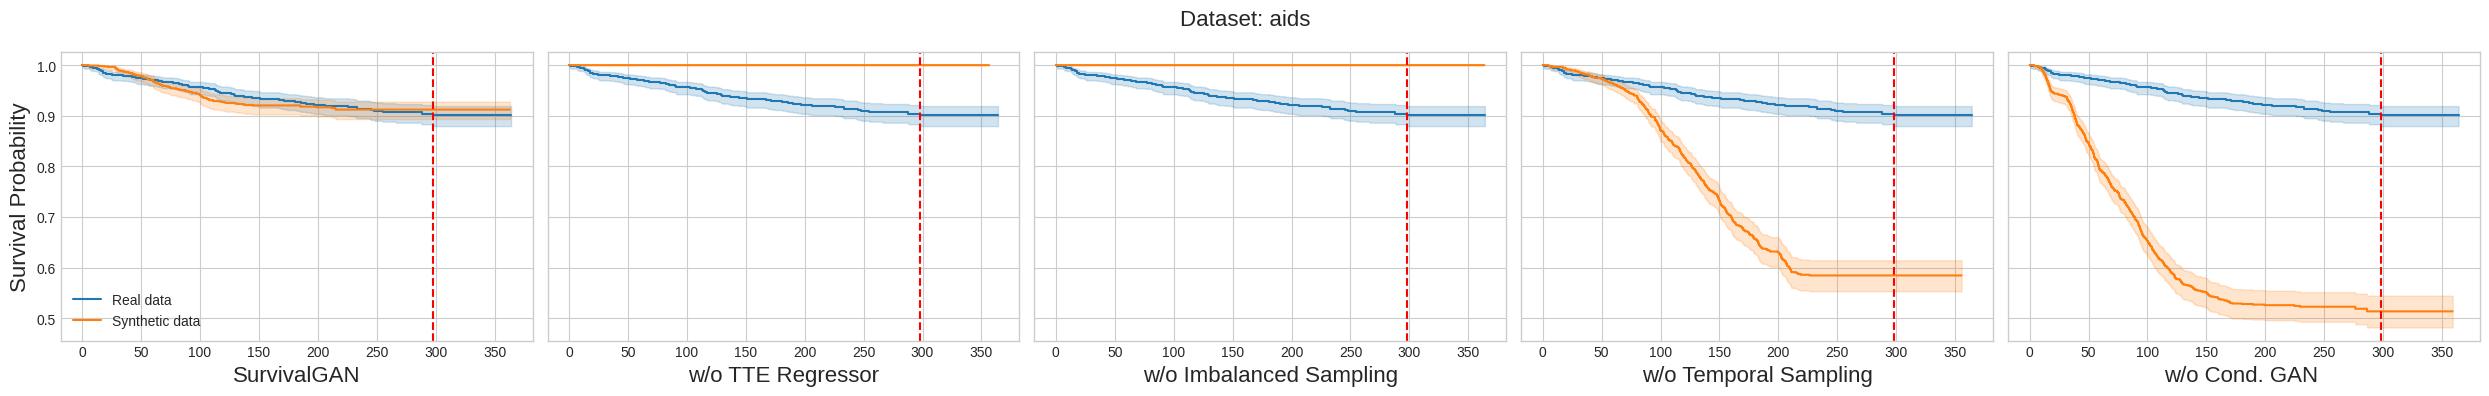

In [20]:
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")

plot_gain_simple("aids", repeat=1)

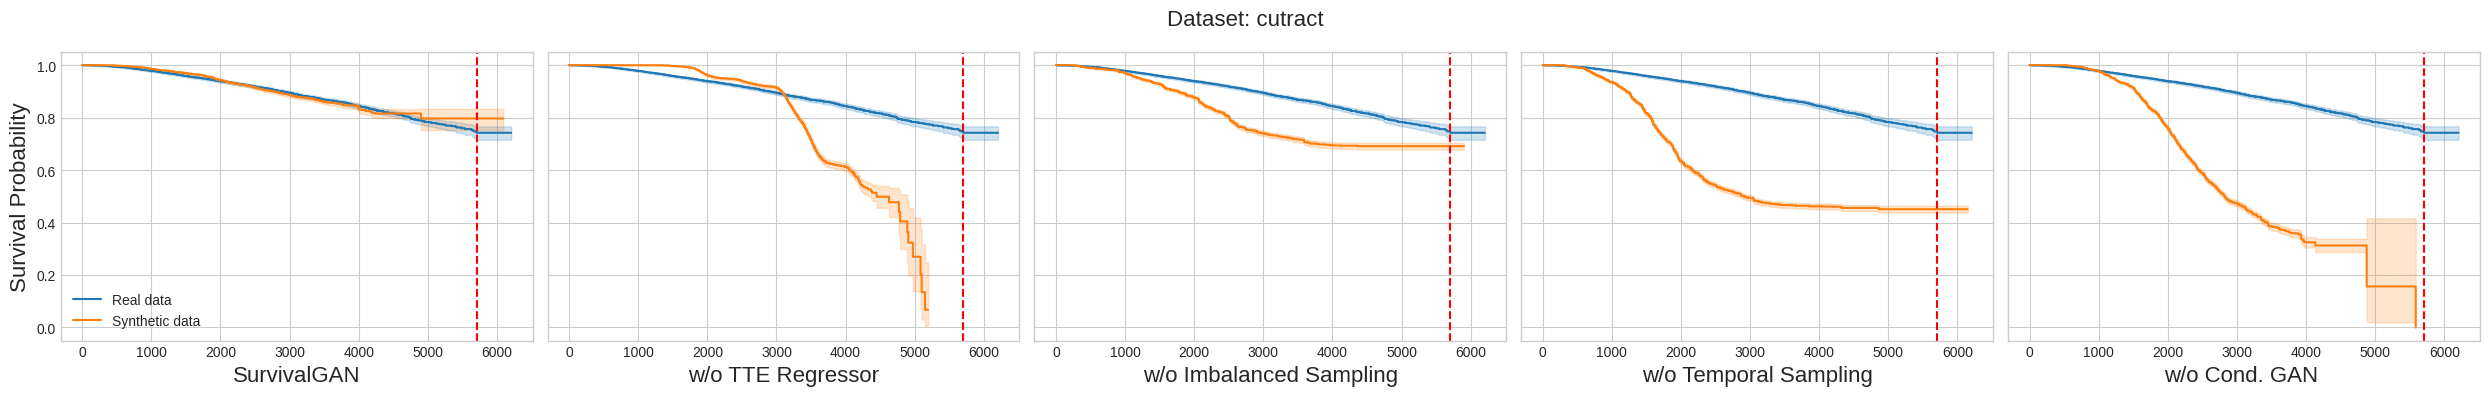

In [21]:
plot_gain_simple("cutract")

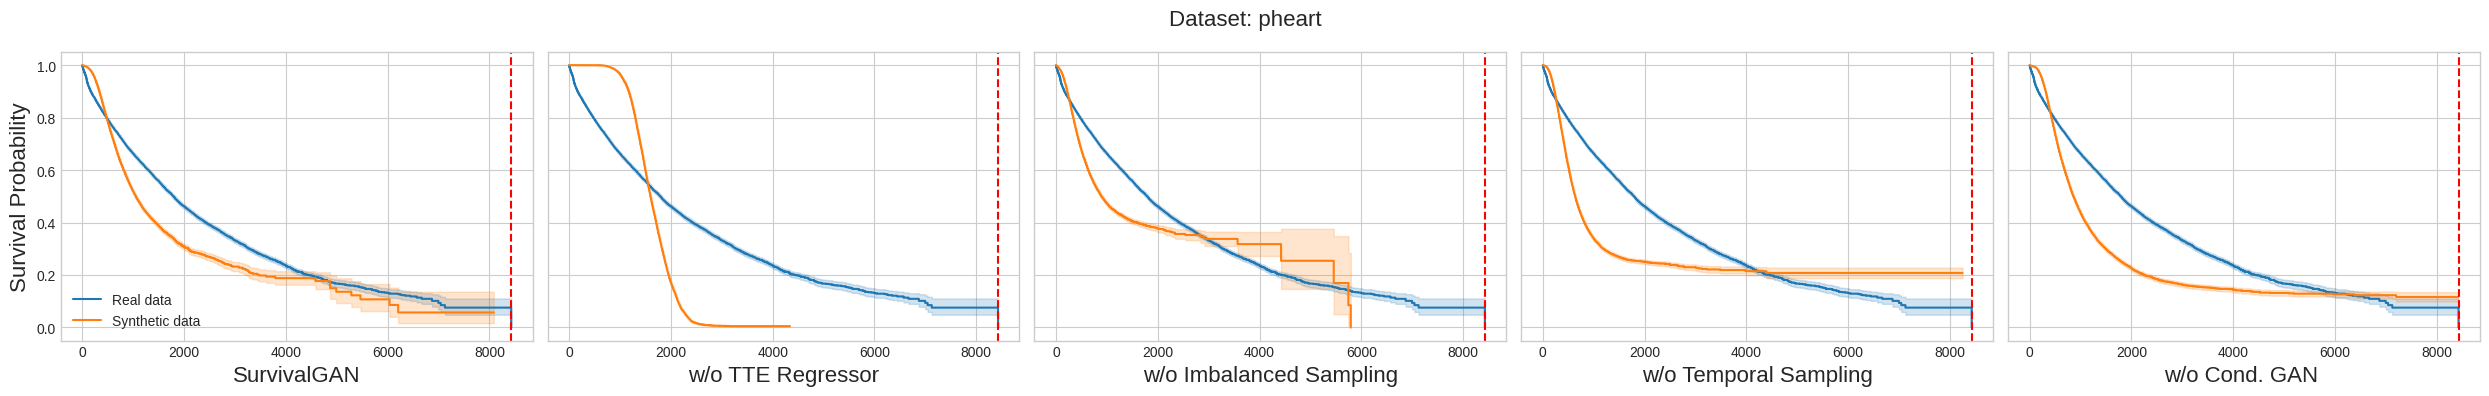

In [22]:
plot_gain_simple("maggic", repeat=1)

missing workspace/5872792679937530807_survival_gan{"dataloader_sampling_strategy": "none", "tte_strategy": "survival_function", "uncensoring_model": "date", "use_conditional": false}_1.bkp


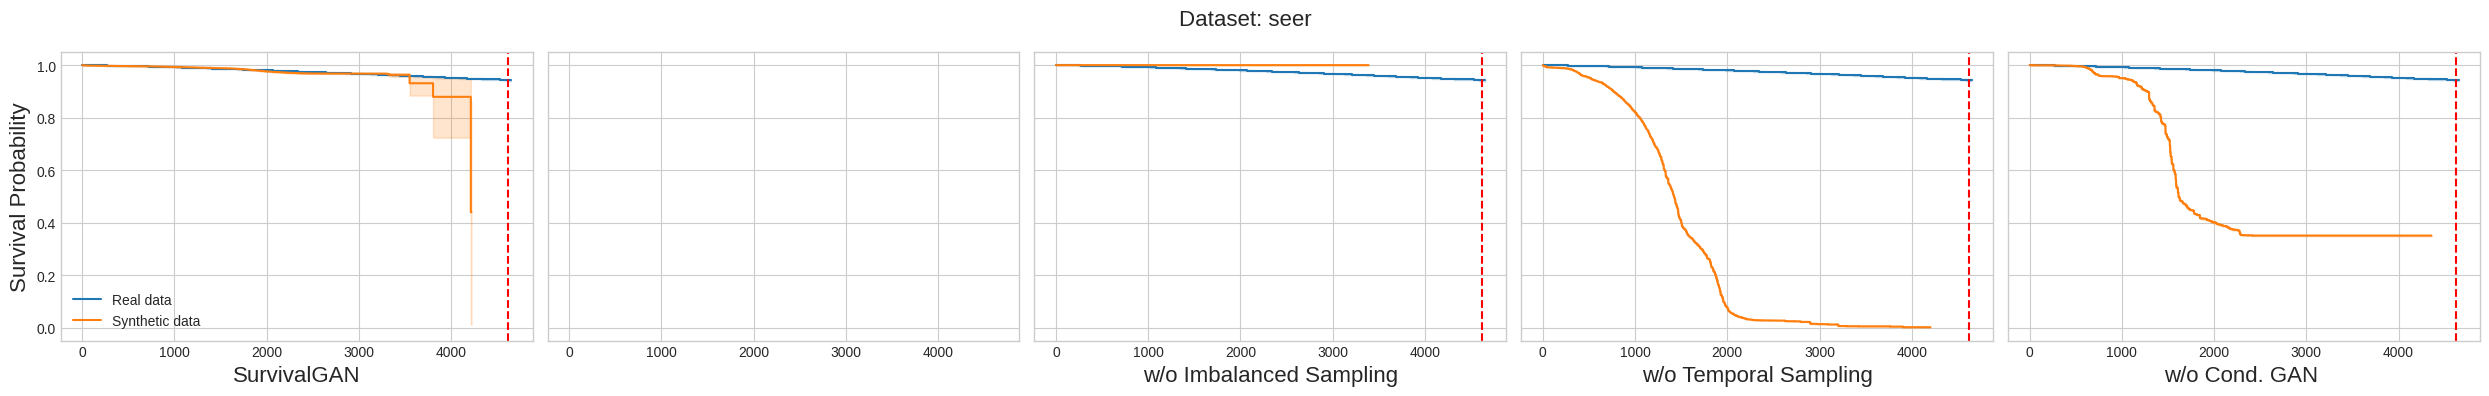

In [23]:
plot_gain_simple("seer", repeat=1)

missing workspace/5872792679937530807_survival_gan{"dataloader_sampling_strategy": "none", "tte_strategy": "survival_function", "uncensoring_model": "date", "use_conditional": false}_1.bkp


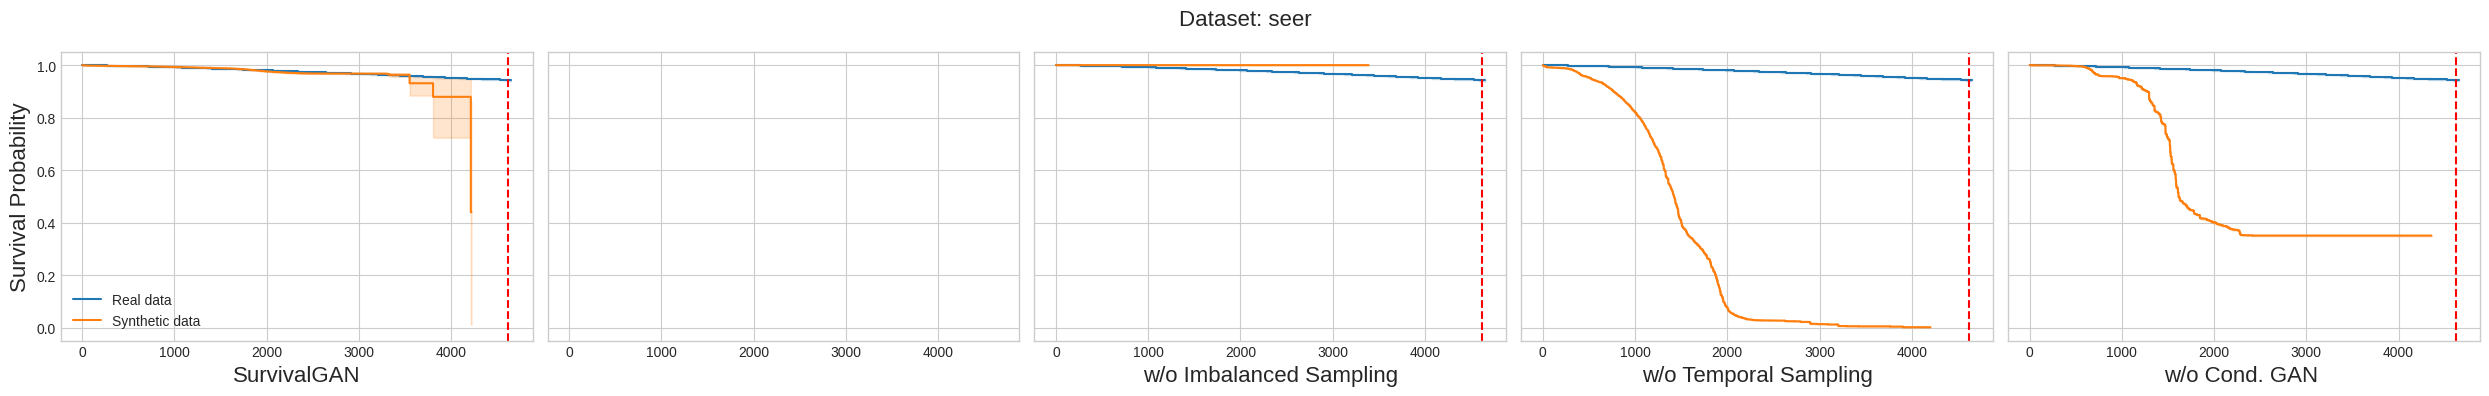

In [24]:
plot_gain_simple("seer", repeat=1)